In [268]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

sns.set(style="whitegrid")

sns.set(style="whitegrid")

In [269]:
# Cell 2: Load Data
train_data = pd.read_csv('../Titanic/data/titanic/train.csv')
test_data = pd.read_csv('../Titanic/data/titanic/test.csv')

In [270]:
# Cell 3: Initial Data Exploration
print(train_data.head())
print(train_data.shape)
print(train_data.info())
print(train_data.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
(8

In [271]:
# Cell 4: Data Cleaning
# Drop 'Cabin' due to many missing values
train_data.drop(columns='Cabin', axis=1, inplace=True)
test_data.drop(columns='Cabin', axis=1, inplace=True)

# Fill missing 'Age' with mean age in both datasets
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)

# Fill missing 'Embarked' with mode
embarked_mode = train_data['Embarked'].mode()[0]
train_data['Embarked'].fillna(embarked_mode, inplace=True)
test_data['Embarked'].fillna(embarked_mode, inplace=True)

In [272]:
# Cell 5: Feature Engineering
# Extract 'Title' from 'Name'
train_data['Title'] = train_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Map titles to numbers
title_map = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3}
train_data['Title'] = train_data['Title'].map(title_map).fillna(4)
test_data['Title'] = test_data['Title'].map(title_map).fillna(4)

# Map 'Sex' and 'Embarked' to numerical values
train_data.replace({'Sex': {'male': 0, 'female': 1}, 'Embarked': {'S': 0, 'C': 1, 'Q': 2}}, inplace=True)
test_data.replace({'Sex': {'male': 0, 'female': 1}, 'Embarked': {'S': 0, 'C': 1, 'Q': 2}}, inplace=True)

# Create 'FamilySize' feature
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

# Create 'FarePerClass' feature
train_data['FarePerClass'] = train_data['Fare'] / train_data['Pclass']
test_data['FarePerClass'] = test_data['Fare'] / test_data['Pclass']

In [273]:
# Cell 6: Define Features and Target
X = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Survived'])
Y = train_data['Survived']

In [274]:
# Cell 7: Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

(891, 10) (712, 10) (179, 10)


In [275]:
# Cell 8: Scale Numerical Features
scaler = StandardScaler()
X_train[['Age', 'Fare', 'FarePerClass']] = scaler.fit_transform(X_train[['Age', 'Fare', 'FarePerClass']])
X_test[['Age', 'Fare', 'FarePerClass']] = scaler.transform(X_test[['Age', 'Fare', 'FarePerClass']])
test_data[['Age', 'Fare', 'FarePerClass']] = scaler.transform(test_data[['Age', 'Fare', 'FarePerClass']])

In [276]:
# Cell 9: Train Logistic Regression Model with Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500]
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_logistic_model = grid_search.best_estimator_

# Train Random Forest and Gradient Boosting Classifiers
model_rf = RandomForestClassifier(n_estimators=100, random_state=2)
model_rf.fit(X_train, Y_train)

model_gb = GradientBoostingClassifier(random_state=2)
model_gb.fit(X_train, Y_train)



GradientBoostingClassifier(random_state=2)

In [277]:
# Cell 10: Ensemble Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('logreg', best_logistic_model), ('rf', model_rf), ('gb', model_gb)],
    voting='soft'
)
voting_clf.fit(X_train, Y_train)

# Evaluate Models
models = {
    "Logistic Regression": best_logistic_model,
    "Random Forest": model_rf,
    "Gradient Boosting": model_gb,
    "Voting Classifier": voting_clf
}

for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    train_accuracy = accuracy_score(Y_train, model.predict(X_train))
    test_accuracy = accuracy_score(Y_test, model.predict(X_test))
    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")
    print("Classification Report:\n", classification_report(Y_test, model.predict(X_test)))


Model: Logistic Regression
Training Accuracy: 0.83
Test Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.81       100
           1       0.79      0.63      0.70        79

    accuracy                           0.77       179
   macro avg       0.77      0.75      0.75       179
weighted avg       0.77      0.77      0.76       179


Model: Random Forest
Training Accuracy: 0.99
Test Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.82      0.73      0.77        79

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179


Model: Gradient Boosting
Training Accuracy: 0.91
Test Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           

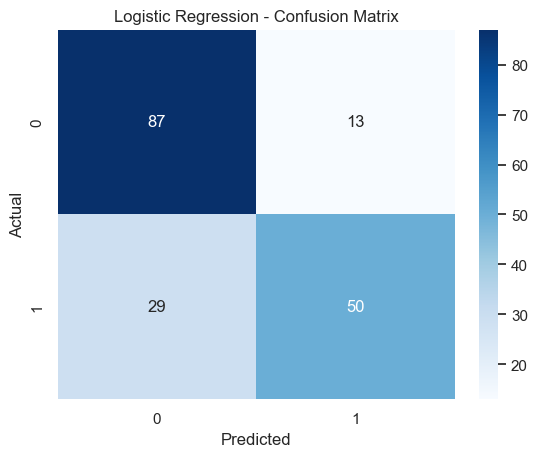

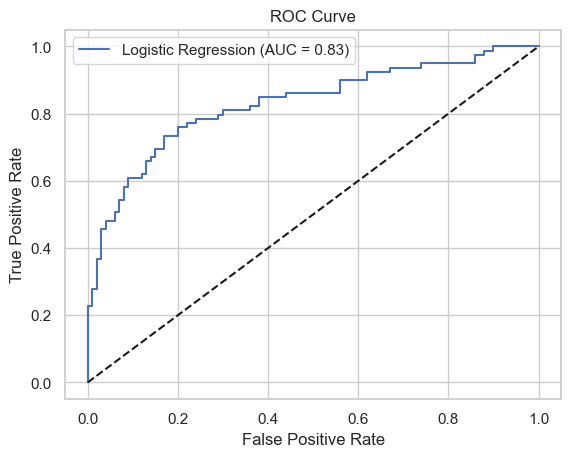

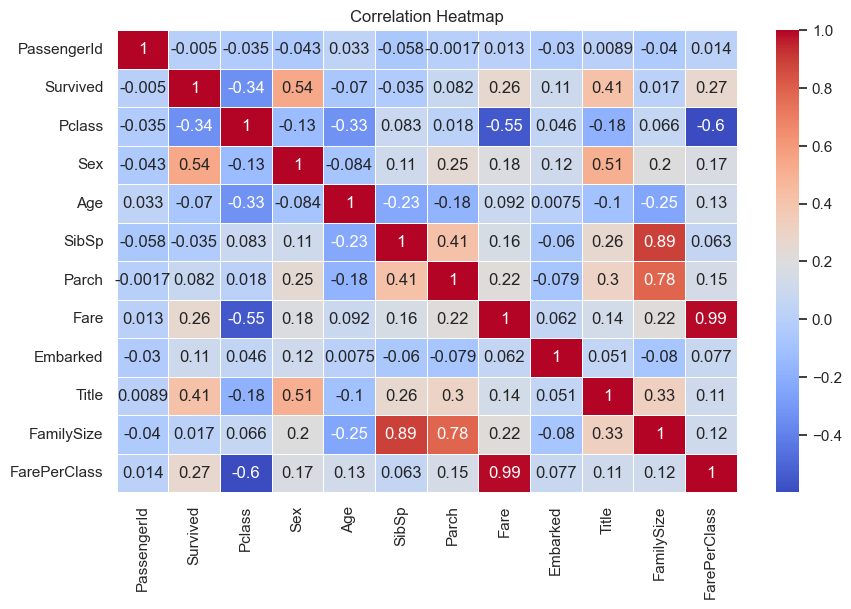

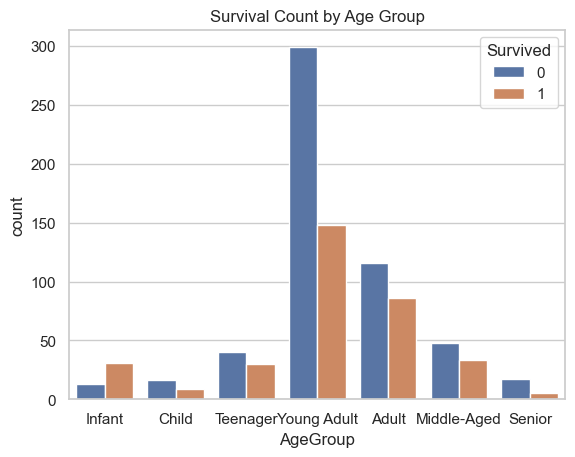

Survival Rate by Age Group:
AgeGroup
Infant         70.454545
Child          36.000000
Teenager       42.857143
Young Adult    33.109620
Adult          42.574257
Middle-Aged    40.740741
Senior         22.727273
Name: Survived, dtype: float64


C:\Users\alame\AppData\Local\Temp\ipykernel_48796\3485982640.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_survival = train_data.groupby('AgeGroup')['Survived'].mean() * 100


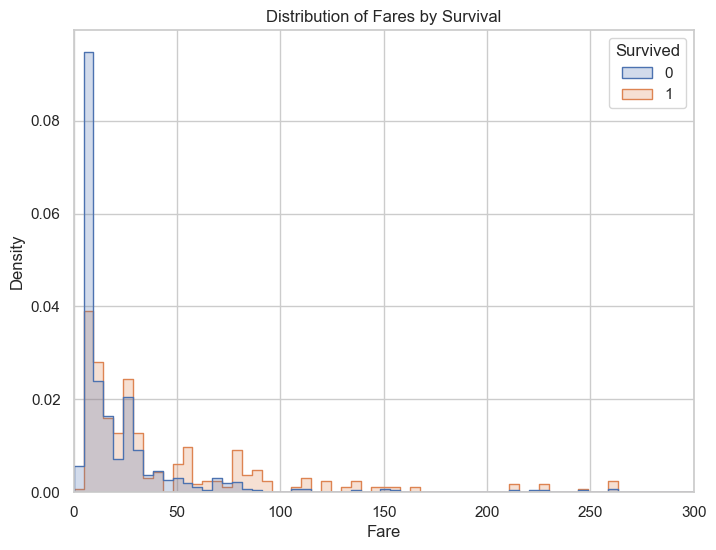

In [278]:
# Cell 11: Visualizations and Insights
# Confusion Matrix for Best Model (Logistic Regression)
conf_matrix = confusion_matrix(Y_test, best_logistic_model.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for Logistic Regression
y_pred_prob = best_logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc_score(Y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

numeric_features = train_data.select_dtypes(include=[np.number])  # Select only numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Age Group Analysis
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=[0, 5, 12, 18, 30, 45, 60, 80], labels=['Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Middle-Aged', 'Senior'])
sns.countplot(x='AgeGroup', hue='Survived', data=train_data)
plt.title('Survival Count by Age Group')
plt.show()

age_group_survival = train_data.groupby('AgeGroup')['Survived'].mean() * 100
print('Survival Rate by Age Group:')
print(age_group_survival)

# Fare Distribution by Survival
plt.figure(figsize=(8, 6))
sns.histplot(data=train_data, x='Fare', hue='Survived', element='step', stat='density', common_norm=False)
plt.title('Distribution of Fares by Survival')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.xlim([0, 300])
plt.show()

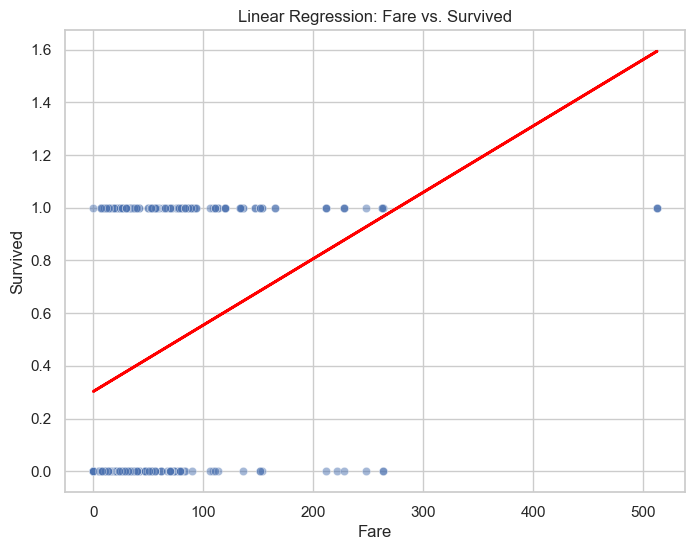

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [286]:
# Cell 12: Visualize Linear Regression (Fare vs. Survived)
lin_reg = LinearRegression()
X_lin = train_data[['Fare']]
y_lin = train_data['Survived']
lin_reg.fit(X_lin, y_lin)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lin['Fare'], y=y_lin, alpha=0.5)
plt.plot(X_lin['Fare'], lin_reg.predict(X_lin), color='red', linewidth=2)
plt.title('Linear Regression: Fare vs. Survived')
plt.xlabel('Fare')
plt.ylabel('Survived')
plt.grid(True)
plt.show()

# Cell 13: Output Submission for Test Data
X_test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket'])
test_predictions = voting_clf.predict(X_test_data)

# Prepare the submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

print(submission.head())
submission.to_csv('titanic_submission.csv', index=False)

In [287]:
# Cell 13: Output Submission for Test Data

# Check for missing values in test data
print(test_data.isnull().sum())

# Impute missing values for numerical columns using mean (if any)
numerical_features = ['Age', 'Fare', 'FarePerClass']
imputer = SimpleImputer(strategy='mean')
test_data[numerical_features] = imputer.fit_transform(test_data[numerical_features])

# Ensure 'Age' and 'Fare' are scaled using the previously fitted scaler
X_test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket'])
X_test_data[numerical_features] = scaler.transform(X_test_data[numerical_features])

# Predict using the voting classifier
test_predictions = voting_clf.predict(X_test_data)

# Prepare the submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

# Display the first few rows of the submission
print(submission.head())
submission.to_csv('titanic_submission.csv', index=False)

PassengerId     0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
Title           0
FamilySize      0
FarePerClass    0
dtype: int64
   PassengerId  Survived
0          892         0
1          893         1
2          894         1
3          895         0
4          896         1


In [255]:
#finding the number of people survived and diod not survive

train_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

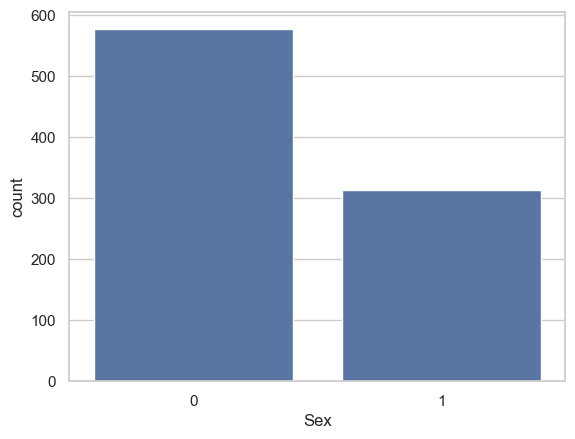

In [144]:
sns.countplot(x='Sex', data=train_data)

# Display the plot
plt.show()

C:\Users\alame\AppData\Local\Temp\ipykernel_48796\2823870710.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=train_data, palette={'0': 'red', '1': 'green'})


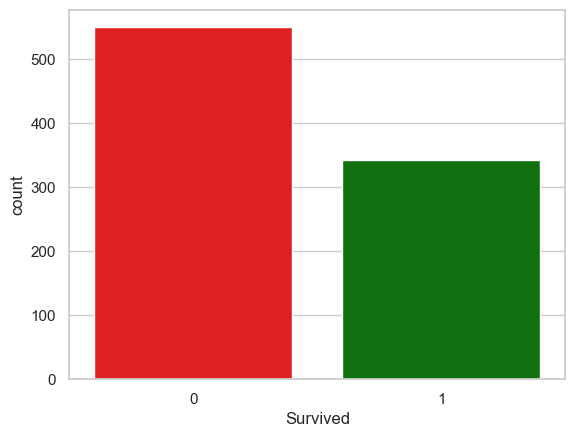

In [143]:
#making a plot for the count for the survived people

sns.countplot(x='Survived', data=train_data, palette={'0': 'red', '1': 'green'})

# Display the plot
plt.show()

<Axes: xlabel='Sex', ylabel='count'>

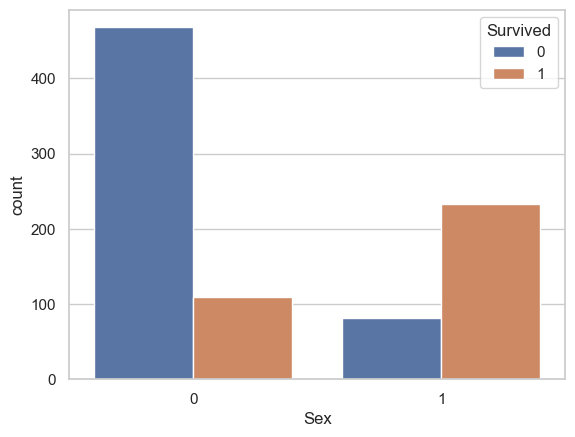

In [145]:
#number of survivors Gender wise
sns.countplot(x='Sex', hue='Survived', data=train_data)

<Axes: xlabel='Pclass', ylabel='count'>

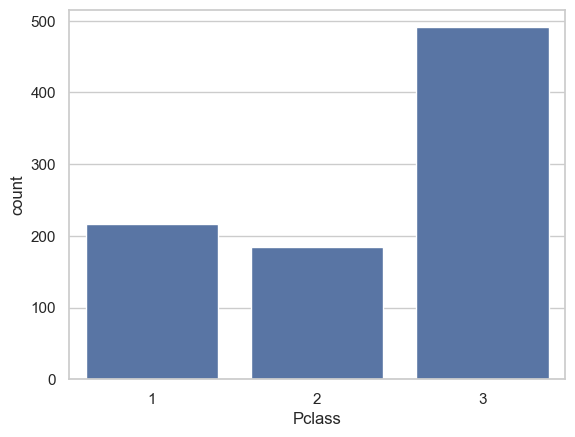

In [146]:
sns.countplot(x='Pclass', data=train_data)

<Axes: xlabel='Pclass', ylabel='count'>

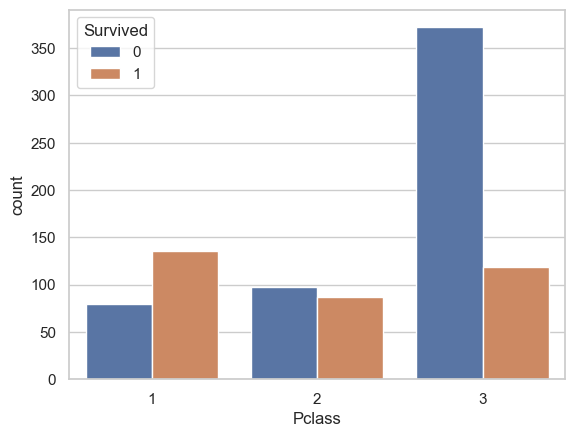

In [147]:
#making count for p class

sns.countplot(x='Pclass', hue='Survived', data=train_data)